In [3]:
import tensorflow as tf
tf.enable_eager_execution()
import numpy as np
import matplotlib.pyplot as plt
from utils import download_img
from IPython import display
from PIL import Image

In [4]:
mean_pixel = np.array([103.939, 116.779, 123.68]).reshape(1,1,1,3)
def normalize(img):
    img = img[:,:,:,[2,1,0]]
    img = img - mean_pixel
    img = img.astype(np.float32)
    return img

def denormalize(img):
    img = img + mean_pixel
    img = np.clip(img,0,255)
    img = img[:,:,:,[2,1,0]]
    img = img.astype(np.int16)
    return img

846 564


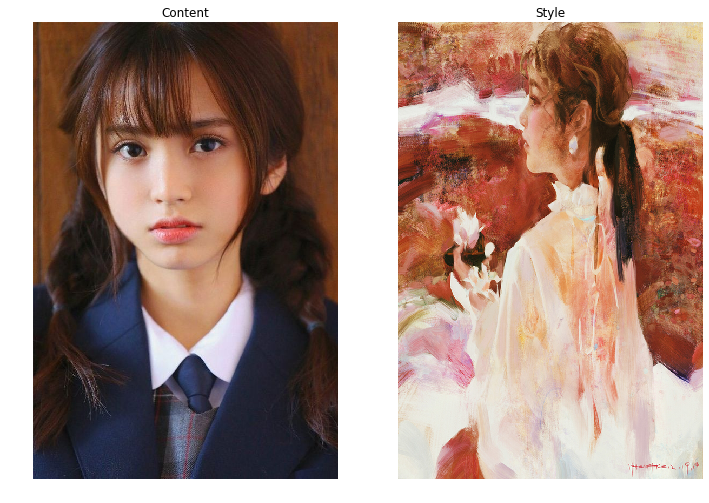

In [316]:
content_url = "https://i.pinimg.com/564x/5e/de/2c/5ede2c43640ba51544aacd49d28bf2c0.jpg"
content = download_img(content_url,1)

h,w = content.shape[0:2]
print(h,w)
style_url = "https://cdna.artstation.com/p/assets/images/images/016/081/318/large/yizheng-ke-2019-2-4.jpg?1550813584"
style = download_img(style_url,resize=(w,h))

figure = plt.figure(figsize=[12,12])
plt.subplot(121)
plt.imshow(content)
plt.title('Content')
plt.axis('off')
plt.subplot(122)
plt.imshow(style)
plt.title('Style')
plt.axis('off')

content_img = normalize(np.expand_dims(content,axis=0))
style_img = normalize(np.expand_dims(style,axis=0))

In [317]:
vgg = tf.keras.applications.VGG19(weights='imagenet',include_top=False)

In [318]:
vgg.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_16 (InputLayer)        (None, None, None, 3)     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, None, None, 64)    1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, None, None, 64)    36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, None, None, 64)    0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, None, None, 128)   73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, None, None, 128)   147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, None, None, 128)   0         
__________

In [338]:
content_layers = ['block2_conv1']
style_layers = ['block4_conv1']

In [320]:
content_dir = {}
for i in content_layers:
    content_dir[i] =  tf.keras.Model(vgg.input,vgg.get_layer(i).output)
style_dir = {}
for i in style_layers:
    style_dir[i] =  tf.keras.Model(vgg.input,vgg.get_layer(i).output)

In [321]:
def sum_content_activation(img):
    s = []
    for i in content_layers:
        s.append(content_dir[i](img))
    return s

def sum_style_activation(img):
    s = []
    for i in style_layers:
        s.append(style_dir[i](img))
    return s

In [322]:
content_outs = sum_content_activation(content_img)
style_outs = sum_style_activation(style_img)

In [323]:
def cal_content_loss():
    #height width channel
    gen_outs = sum_content_activation(gen_img)
    total_content_loss = 0
    for gen_out,content_out in zip(gen_outs,content_outs):
        content_loss = (content_out - gen_out)**2
        content_loss = tf.reduce_sum(content_loss)/2
        total_content_loss += content_loss
    return total_content_loss

def cal_style_loss():
    gen_outs = sum_style_activation(gen_img)
    total_style_loss = 0
    def gram_matrix(activation_out,m,n):
        A = tf.reshape(activation_out,(m,n))
        return tf.matmul(tf.transpose(A),A)
    for gen_out,style_out in zip(gen_outs,style_outs):
        n,h,w,c = gen_out.get_shape().as_list()
        prod = h*w
        style_loss = (gram_matrix(style_out,h*w,c) - gram_matrix(gen_out,h*w,c))**2
        style_loss = tf.reduce_sum(style_loss)/(4*prod**2)
        total_style_loss+=style_loss
    total_style_loss /= len(style_layers)
    return total_style_loss

def cal_total_loss():
    #content_loss = cal_content_loss()
    style_loss = cal_style_loss()
    # Measure how noisy the image is
    total_variational_loss = tf.image.total_variation(gen_img)
    total_loss = beta*style_loss+theta*total_variational_loss
    return total_loss

In [324]:
beta = 3
theta = 100

In [331]:
gen_img = tf.get_variable("gen_image",initializer=content_img)

In [335]:
optimizer = tf.train.AdamOptimizer(10)
loss_history = []

In [336]:
def save_image(img,c):
    img = Image.fromarray(np.uint8(img))
    img.save("./export/"+str(c)+".jpg")

In [337]:
c = 1
for i in range(300):
    with tf.GradientTape() as tape:
        loss = cal_total_loss()
    grads = tape.gradient(loss,gen_img)
    optimizer.apply_gradients(zip([grads],[gen_img]),global_step=tf.train.get_or_create_global_step())
    if (i%10 == 0):
        loss_history.append(loss.numpy())
        temp_img = denormalize(gen_img.numpy())
        imgs = np.clip(temp_img[0],0,255)
        plt.figure(figsize=[7,7])
        plt.imshow(imgs)
        #save_image(temp_img,c)
        plt.axis('off')
        plt.title("iteration {}: {}".format(i,loss.numpy()))
        plt.pause(1e-100)
        plt.close('all')
        c+=1
        display.clear_output(wait=True)

KeyboardInterrupt: 

In [ ]:
figure = plt.figure(figsize=[15,15])
plt.subplot(131)
plt.imshow(content)
plt.title('Content')
plt.axis('off')
plt.subplot(132)
plt.imshow(style)
plt.title('Style')
plt.axis('off')
plt.subplot(133)
temp_img = denormalize(gen_img.numpy())
imgs = np.clip(temp_img[0],0,255)
plt.imshow(imgs)
plt.title('Result')
plt.axis('off')

In [261]:
export_img = Image.fromarray(np.uint8(imgs))

scale = 2
new_size = (scale*export_img.width,scale*export_img.height)

export_img = export_img.resize(export_img.size,Image.ANTIALIAS)

export_img.save('./sample.png')